# Importing Libraries 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Dropout, concatenate, BatchNormalization, MultiHeadAttention, LayerNormalization, LeakyReLU, Flatten,
                                      Embedding, Lambda, Add,  Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Bidirectional, LSTM)
from tensorflow.keras.optimizers import Adam
import json
import os

# Data Loading and Exploration

In [4]:
excel_path = r'c:/Users/LENOVO/OneDrive/Desktop/capstone project/13059_2018_1459_MOESM5_ESM.xlsx'
xls = pd.ExcelFile(excel_path)
sheets = xls.sheet_names
dfs = {sheet: xls.parse(sheet) for sheet in sheets}

hct116_df=dfs['hct116']
hek293t_df=dfs['hek293t']
hela_df=dfs['hela']
hl60_df=dfs['hl60']

In [5]:
print(f'HCT116 shape: {hct116_df.shape}')
print(f'HEK293T shape: {hek293t_df.shape}')
print(f'HELA shape: {hela_df.shape}')
print(f'HL60 shape: {hl60_df.shape}')

HCT116 shape: (4239, 6)
HEK293T shape: (2333, 6)
HELA shape: (8101, 6)
HL60 shape: (2076, 6)


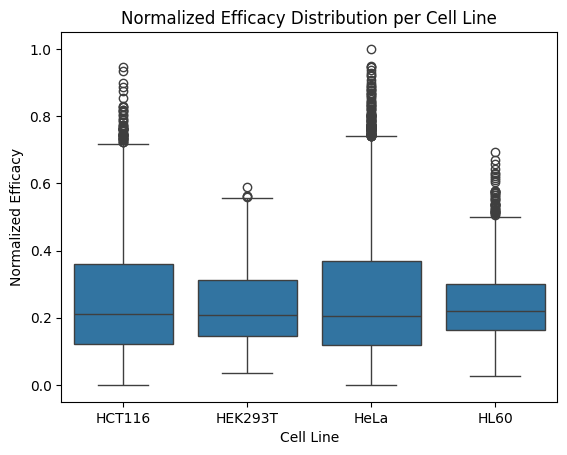

In [6]:
combined_df = pd.concat([
    hct116_df.assign(CellLine='HCT116'),
    hek293t_df.assign(CellLine='HEK293T'),
    hela_df.assign(CellLine='HeLa'),
    hl60_df.assign(CellLine='HL60')
])

sns.boxplot(data=combined_df, x='CellLine', y='Normalized efficacy')
plt.title('Normalized Efficacy Distribution per Cell Line')
plt.ylabel('Normalized Efficacy')
plt.xlabel('Cell Line')
plt.show()

In [7]:
'''
hct116_df.to_csv('hct116.csv', index=False)
hek293t_df.to_csv('hek293t.csv', index=False)
hela_df.to_csv('hela_df.csv', index=False)
hl60_df.to_csv('hl60_df.csv', index=False)
'''

"\nhct116_df.to_csv('hct116.csv', index=False)\nhek293t_df.to_csv('hek293t.csv', index=False)\nhela_df.to_csv('hela_df.csv', index=False)\nhl60_df.to_csv('hl60_df.csv', index=False)\n"

In [8]:
df=hl60_df.copy()

In [9]:
df

,Chromosome,Start,End,Strand,sgRNA,Normalized efficacy
0,chr3,53916065,53916087,-,GAAGGGCGGCGAGAAGGAGAAGG,0.286080
1,chr3,53916079,53916101,-,GAGAACGGAAAGGAGAAGGGCGG,0.400080
2,chr3,53916094,53916116,-,GAGAAGGGTGATACGGAGAACGG,0.282833
3,chr3,53916119,53916141,-,GTCTCCGGCCATAATGACCCAGG,0.171695
4,chr18,60985747,60985769,+,GGAGGAGAAGATGCCCGGTGCGG,0.429027
...,...,...,...,...,...,...
2071,chr19,54710145,54710167,+,CAACGCCCTGCTGCGGCGGCTGG,0.287346
2072,chr19,54710220,54710242,-,CTAAGAAATCCTCTATCTTCAGG,0.209103
2073,chr19,54710309,54710331,+,TGATCCGCCAGCGCCATATCAGG,0.061508
2074,chr19,54710322,54710344,-,ATCCGAGGTGGTACCTGATATGG,0.181219


In [10]:
df.shape

(2076, 6)

In [11]:
print("Max:", round(df['Normalized efficacy'].max(),3))
print("Min:", round(df['Normalized efficacy'].min(),3))

p1 = df['Normalized efficacy'].quantile(0.25)
p2 = df['Normalized efficacy'].quantile(0.50)
p3 = df['Normalized efficacy'].quantile(0.75)

print("25th percentile (Q1):", round(p1,3))
print("50th percentile (Median):", round(p2,3))
print("75th percentile (Q3):", round(p3,3))

Max: 0.693
Min: 0.028
25th percentile (Q1): 0.164
50th percentile (Median): 0.22
75th percentile (Q3): 0.3


In [12]:
df.describe()

,Start,End,Normalized efficacy
count,2.076000e+03,2.076000e+03,2076.000000
mean,6.662495e+07,6.662497e+07,0.232169
std,4.773981e+07,4.773981e+07,0.113508
min,1.015960e+05,1.016180e+05,0.027783
25%,3.438954e+07,3.438956e+07,0.163870
50%,5.469527e+07,5.469529e+07,0.219842
75%,9.903673e+07,9.903675e+07,0.299855
max,2.367674e+08,2.367674e+08,0.692699


In [13]:
df.dtypes

Chromosome              object
Start                    int64
End                      int64
Strand                  object
sgRNA                   object
Normalized efficacy    float64
dtype: object

In [14]:
df.info

<bound method DataFrame.info of      Chromosome     Start       End Strand                    sgRNA  \
0          chr3  53916065  53916087      -  GAAGGGCGGCGAGAAGGAGAAGG   
1          chr3  53916079  53916101      -  GAGAACGGAAAGGAGAAGGGCGG   
2          chr3  53916094  53916116      -  GAGAAGGGTGATACGGAGAACGG   
3          chr3  53916119  53916141      -  GTCTCCGGCCATAATGACCCAGG   
4         chr18  60985747  60985769      +  GGAGGAGAAGATGCCCGGTGCGG   
...         ...       ...       ...    ...                      ...   
2071      chr19  54710145  54710167      +  CAACGCCCTGCTGCGGCGGCTGG   
2072      chr19  54710220  54710242      -  CTAAGAAATCCTCTATCTTCAGG   
2073      chr19  54710309  54710331      +  TGATCCGCCAGCGCCATATCAGG   
2074      chr19  54710322  54710344      -  ATCCGAGGTGGTACCTGATATGG   
2075      chr19  54711334  54711356      +  TCTCTCTGCGCTCTCCCTACGGG   

      Normalized efficacy  
0                0.286080  
1                0.400080  
2                0.282833  
3  

In [15]:
df.isnull().sum()

Chromosome             0
Start                  0
End                    0
Strand                 0
sgRNA                  0
Normalized efficacy    0
dtype: int64

In [16]:
df.duplicated().sum()

0

# Data Augmentation

In [17]:
nucleotides = ['A', 'C', 'G', 'T']

def generate_sgrnas(sgRNA):
    augmented = []
    for i in nucleotides:
        for j in nucleotides:
            if sgRNA[0] == i and sgRNA[1] == j:
                continue
            new_sgRNA = i + j + sgRNA[2:]
            if len(new_sgRNA) == len(sgRNA):
                augmented.append(new_sgRNA)
    return random.sample(augmented, min(3, len(augmented))) #To ensure that the max augmented sample=16 (even if the more that 16) 

augmented_rows = []

for _, row in df.iterrows():
    sgRNA = row['sgRNA']
    aug_sgrnas = generate_sgrnas(sgRNA)
    for i in aug_sgrnas:
        new_row = row.copy()
        new_row['sgRNA'] = i
        augmented_rows.append(new_row)
        
df_augmented = pd.DataFrame(augmented_rows)

In [18]:
df_augmented.shape

(6228, 6)

In [19]:
df_combined= pd.concat([df, df_augmented], ignore_index=True)

In [20]:
df_combined = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

In [21]:
'''
df_augmented.to_csv('hl60_augmented.csv', index=False)
df_combined.to_csv('hl60_combined.csv', index=False)
'''

"\ndf_augmented.to_csv('hl60_augmented.csv', index=False)\ndf_combined.to_csv('hl60_combined.csv', index=False)\n"

In [22]:
df=df_combined.copy()

In [23]:
df.shape

(8304, 6)

# Feature Engineering

In [24]:
def gc_content(seq):
    gc_count = seq.count('G') + seq.count('C')
    return (gc_count / len(seq)) * 100

df['GC content']= df['sgRNA'].apply(gc_content)

In [25]:
print("Minimum GC Content: " , round(df['GC content'].min(),3))
print("Maximum GC Content: ", round(df['GC content'].max(),3))

Minimum GC Content:  21.739
Maximum GC Content:  91.304


In [26]:
df['Length'] = df['sgRNA'].apply(len)
df['Length'].value_counts()

Length
23    8304
Name: count, dtype: int64

In [27]:
df['sgRNA_noPAM'] = df['sgRNA'].apply(lambda x: x[:-3])
df['Length_noPAM'] = df['sgRNA_noPAM'].apply(len)

In [28]:
df['Length_noPAM'].value_counts()

Length_noPAM
20    8304
Name: count, dtype: int64

In [29]:
df.columns

Index(['Chromosome', 'Start', 'End', 'Strand', 'sgRNA', 'Normalized efficacy',
       'GC content', 'Length', 'sgRNA_noPAM', 'Length_noPAM'],
      dtype='object')

In [30]:
df=df.drop(['Length','Length_noPAM', 'sgRNA'], axis=1)
df

,Chromosome,Start,End,Strand,Normalized efficacy,GC content,sgRNA_noPAM
0,chr9,136217555,136217577,-,0.275434,60.869565,CACCTGTGTGAAGGCGACAG
1,chrX,71493752,71493774,+,0.376541,43.478261,AAATCATGAGTCACCAGATG
2,chr1,43852656,43852678,-,0.229943,60.869565,CCGTTACAGCGGCAGACTGA
3,chr3,52304764,52304786,+,0.244814,47.826087,TCGCATGAGTGTATCTGATG
4,chrX,71494976,71494998,-,0.467964,52.173913,TCCATCAGCATTGACAAGAC
...,...,...,...,...,...,...,...
8299,chr15,66794949,66794971,+,0.377311,43.478261,AATTTAGACATGACCAGTGC
8300,chr19,49119982,49120004,-,0.196514,47.826087,AAAGGAGGTACCCAAACTGA
8301,chr17,27049769,27049791,-,0.194105,65.217391,GAGGCAGACTCAGTGGTCAG
8302,chr2,96970567,96970589,+,0.072027,52.173913,CAATGAGAGAACGGTCAGCT


# One Hot Encoding

In [31]:
nucleotides = ['A', 'T', 'C', 'G']
encoder = OneHotEncoder(categories=[nucleotides], handle_unknown='ignore')
def one_hot_encoder(sequence):
    seq_arr = np.array(list(sequence)).reshape(-1, 1)
    return encoder.fit_transform(seq_arr).toarray()

result = df['sgRNA_noPAM'].apply(one_hot_encoder)
one_hot_arr = np.stack(result.to_numpy())  # shape: (samples, seq_len, 4)

# K mer encoding

In [29]:
def kmer_encoder(seqs):
    kmers = []
    k=3
    for seq in seqs:
        kmer_list = [seq[i:i+k] for i in range(len(seq) - k + 1)]
        kmer_str = ' '.join(kmer_list)
        kmers.append(kmer_str)
    vectorizer = CountVectorizer()
    k_mer_arr = vectorizer.fit_transform(kmers).toarray()

    return k_mer_arr, vectorizer

kmer_arr, kmer_vec= kmer_encoder(df['sgRNA_noPAM'])

In [30]:
kmer_arr.shape

(8304, 64)

# Data Preperation & Splitting

## Data Preperation with One Hot Encoding

### With Feature Engineering

In [32]:
strand_map = {'+': 0, '-': 1}
df['Strand'] = df['Strand'].map(strand_map)
df['Chromosome_number'] = df['Chromosome'].str.replace('chr', '', regex=False).astype(str)
df['Chromosome_number'] = df['Chromosome_number'].replace({'X': 23})
df['Chromosome_number'] = df['Chromosome_number'].astype(int)

features_df = df[['Chromosome_number', 'Start', 'End', 'Strand', 'GC content']].copy()

y = df['Normalized efficacy'].values

X_seq_train, X_seq_test, X_feat_train, X_feat_test, y_train, y_test = train_test_split(
    one_hot_arr, features_df, y, test_size=0.2, random_state=42
)

scaler_gc = MinMaxScaler()
X_feat_train['GC content'] = scaler_gc.fit_transform(X_feat_train[['GC content']])
X_feat_test['GC content'] = scaler_gc.transform(X_feat_test[['GC content']])

X_num_train = X_feat_train.values
X_num_test = X_feat_test.values

### Without Feature Engineering

In [ ]:
strand_map = {'+': 0, '-': 1}
df['Strand'] = df['Strand'].map(strand_map)
df['Chromosome_number'] = df['Chromosome'].str.replace('chr', '', regex=False).astype(str)
df['Chromosome_number'] = df['Chromosome_number'].replace({'X': 23})
df['Chromosome_number'] = df['Chromosome_number'].astype(int)

features_df = df[['Chromosome_number', 'Start', 'End', 'Strand']].copy()

y = df['Normalized efficacy'].valuesa

X_seq_train, X_seq_test, X_feat_train, X_feat_test, y_train, y_test = train_test_split(
    one_hot_arr, features_df, y, test_size=0.2, random_state=42
)

X_num_train = X_feat_train.values
X_num_test = X_feat_test.values

## Data Preperation with K-mers Encoding

### With Feature Engineering

In [31]:
strand_map = {'+': 0, '-': 1}
df['Strand'] = df['Strand'].map(strand_map)
df['Chromosome_number'] = df['Chromosome'].str.replace('chr', '', regex=False).astype(str)
df['Chromosome_number'] = df['Chromosome_number'].replace({'X': 23})
df['Chromosome_number'] = df['Chromosome_number'].astype(int)

features_df = df[['Chromosome_number', 'Start', 'End', 'Strand', 'GC content']].copy()

y = df['Normalized efficacy'].values

X_seq_train, X_seq_test, X_feat_train, X_feat_test, y_train, y_test = train_test_split(
    kmer_arr, features_df, y, test_size=0.2, random_state=42
)

scaler_gc = MinMaxScaler()
X_feat_train['GC content'] = scaler_gc.fit_transform(X_feat_train[['GC content']])
X_feat_test['GC content'] = scaler_gc.transform(X_feat_test[['GC content']])

X_num_train = X_feat_train.values
X_num_test = X_feat_test.values

### Without Feature Engineering

In [ ]:
strand_map = {'+': 0, '-': 1}
df['Strand'] = df['Strand'].map(strand_map)
df['Chromosome_number'] = df['Chromosome'].str.replace('chr', '', regex=False).astype(str)
df['Chromosome_number'] = df['Chromosome_number'].replace({'X': 23})
df['Chromosome_number'] = df['Chromosome_number'].astype(int)

features_df = df[['Chromosome_number', 'Start', 'End', 'Strand']].copy()

y = df['Normalized efficacy'].values

X_seq_train, X_seq_test, X_feat_train, X_feat_test, y_train, y_test = train_test_split(
    kmer_arr, features_df, y, test_size=0.2, random_state=42
)

X_num_train = X_feat_train.values
X_num_test = X_feat_test.values

# Saving models

In [38]:
def save_run(type, model, data, encoding_method, feature_engineering, run_id, hyperparameters, metrics, plots):

    dir = os.path.join("/Users/LENOVO/OneDrive/Desktop/hl60", "Testing Models")
    os.makedirs(dir, exist_ok=True)

    plot_paths = {}
    for name, fig in plots.items():
        path = os.path.join(dir, f"{name}_run{run_id}.png")
        fig.savefig(path)
        plt.close(fig)
        plot_paths[name] = path

    model_arch_path = None
    if model is not None:
        model_arch_path = os.path.join(dir, f"model_architecture_run_{run_id}.txt")
        with open(model_arch_path, "w", encoding="utf-8") as f:
            model.summary(print_fn=lambda x: f.write(x + "\n"))
    
    model_file_path = None
    if model is not None:
        model_file_path = os.path.join(dir, f"model_run_{run_id}.keras")
        model.save(model_file_path) 

    run = {
        "Model:": type,
        "Run_id": run_id,
        "Data": data,
        "Encoding Method": encoding_method,
        "Feature Engineering": feature_engineering,
        "Hyperparameters": hyperparameters,
        "Evaluation Metrics": metrics,
        "Plots": plot_paths,
        "Model Architecture": model_arch_path,
        "Model Path": model_file_path
    }

    json_path = os.path.join(dir, "runs.json")
    if os.path.exists(json_path):
        with open(json_path, "r") as f:
            all_runs = json.load(f)
    else:
        all_runs = []

    all_runs.append(run)

    with open(json_path, "w") as f:
        json.dump(all_runs, f, indent=2)
        
    print("Done")

# MLP

### Normal MLP

In [35]:
#seq_len=20 #With one-hot encoding
#seq_input = Input(shape=(seq_len,4), name='seq_input') #With one-hot encoding
seq_len = 64  #With k-mers encoding
seq_input = Input(shape=(seq_len,), name="seq_input") #With k-mers encoding

#x1 = Flatten()(seq_input) #Only with 1-Hot encoding
x1 = Dense(256, kernel_initializer='he_normal')(seq_input) #seq_input instead of x1 if k-mers
x1 = LeakyReLU()(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.3)(x1)

x1 = Dense(128, kernel_initializer='he_normal')(x1)
x1 = LeakyReLU()(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)

x1 = Dense(64, kernel_initializer='he_normal')(x1)
x1 = LeakyReLU()(x1)
x1 = BatchNormalization()(x1)

features_input = Input(shape=(X_num_train.shape[1],), name='num_input')
x2 = Dense(64, activation='relu', kernel_initializer='he_normal')(features_input)
x2 = BatchNormalization()(x2)

all_input = concatenate([x1, x2])
z = Dense(128, activation='relu', kernel_initializer='he_normal')(all_input)
z = Dropout(0.2)(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(1, activation='linear')(z)

optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)
model = Model(inputs=[seq_input, features_input], outputs=z)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history = model.fit(
    {'seq_input': X_seq_train, 'num_input': X_num_train},
    y_train,
    validation_data=({'seq_input': X_seq_test, 'num_input': X_num_test}, y_test),
    epochs= 400,
    batch_size= 32
)

Epoch 1/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4965 - mae: 0.5373 - val_loss: 0.0384 - val_mae: 0.1532
Epoch 2/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1095 - mae: 0.2602 - val_loss: 0.0318 - val_mae: 0.1392
Epoch 3/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0712 - mae: 0.2092 - val_loss: 0.0253 - val_mae: 0.1241
Epoch 4/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0531 - mae: 0.1802 - val_loss: 0.0237 - val_mae: 0.1193
Epoch 5/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0427 - mae: 0.1627 - val_loss: 0.0203 - val_mae: 0.1100
Epoch 6/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0360 - mae: 0.1501 - val_loss: 0.0191 - val_mae: 0.1063
Epoch 7/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0307 - mae: 0.1380 - val_loss: 0.0177 - val_mae: 0.1024
Epoch 8/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0276 - mae: 0.1312 - val_loss: 0.0176 - val_mae: 0.1013
Epoch 9/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

In [36]:
y_pred= model.predict({'seq_input': X_seq_test, 'num_input': X_num_test})
y_pred = y_pred.ravel()
y_test = y_test.ravel()

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [37]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
spearman_corr, _ = spearmanr(y_test, y_pred)

metrics = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2,
    'Spearman': spearman_corr
}

print("MLP Evaluation Metrics:")
print(f"  MSE      : {round(mse,3)}")
print(f"  RMSE     : {round(rmse,3)}")
print(f"  MAE      : {round(mae,3)}")
print(f"  R2 Score : {round(r2,3)}")
print(f"  Spearman : {round(spearman_corr,3)}")

MLP Evaluation Metrics:
  MSE      : 0.003
  RMSE     : 0.058
  MAE      : 0.044
  R2 Score : 0.736
  Spearman : 0.828


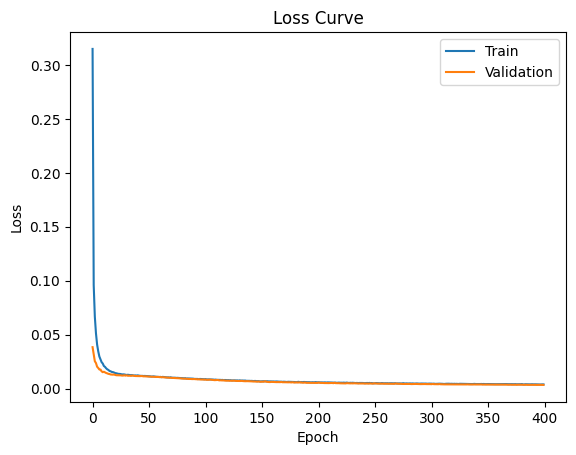

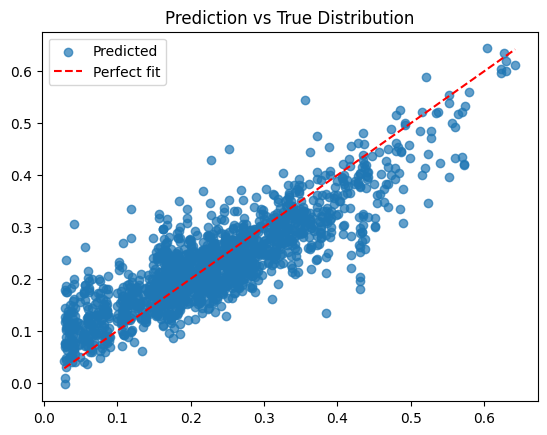

In [38]:
fig1, ax1 = plt.subplots()
ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Validation')
ax1.set_xlabel('Epoch')        
ax1.set_ylabel('Loss') 
ax1.set_title('Loss Curve')
ax1.legend()

fig2, ax2 = plt.subplots()
ax2.scatter(y_test, y_pred, alpha=0.7, label='Predicted')
ax2.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect fit') 
ax2.set_title('Prediction vs True Distribution')
ax2.legend()

In [39]:
data= "Augmented Data"
encoding_method= 'K-mers Encoding'
feature_engineering= "With Feature Engineering"
run_id = 2
model_type = "MLP"
hyperparameters = {
    "epochs": 400,
    "batch_size": 32,
    "learning_rate": 1e-4
}

plots = {
    "Loss Curve": fig1,
    "Predicted vs. True Distribution": fig2
}

save_run(model_type, model, data, encoding_method, feature_engineering, run_id, hyperparameters, metrics, plots)

Done


### MLP with Attention

In [ ]:
seq_len = 20        
d_model = 16 

seq_input = Input(shape=(seq_len,4), name='seq_input')
x = Dense(d_model, use_bias=False)(seq_input)  # (Projection)
position_embed = Embedding(input_dim=seq_len, output_dim=d_model)

def add_positional_encoding(t):
    pe = position_embed(tf.range(seq_len))                        
    return t + tf.expand_dims(pe, 0)

x = Lambda(add_positional_encoding, name='add_pos')(x) 

attention_output = MultiHeadAttention(num_heads=2, key_dim=d_model // 2, dropout=0.1, name='self_attn')(x, x)      

x = Add(name='attn_res')([x, attention_output])
x = LayerNormalization(name='attn_ln')(x)
attention_output = Flatten(name='gap')(x)    

x1 = Dense(256, kernel_initializer='he_normal')(attention_output)
x1 = LeakyReLU()(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)

x1 = Dense(128, kernel_initializer='he_normal')(x1)
x1 = LeakyReLU()(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)

x1 = Dense(64, kernel_initializer='he_normal')(x1)
x1 = LeakyReLU()(x1)
x1 = BatchNormalization()(x1)

features_input = Input(shape=(X_num_train.shape[1],), name='num_input')
x2 = Dense(64, activation='relu', kernel_initializer='he_normal')(features_input)
x2 = BatchNormalization()(x2)

all_input = concatenate([x1, x2])
z = Dense(128, activation='relu', kernel_initializer='he_normal')(all_input)
z = Dropout(0.2)(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(1, activation='linear')(z)

optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)
model = Model(inputs=[seq_input, features_input], outputs=z)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history = model.fit(
    {'seq_input': X_seq_train, 'num_input': X_num_train},
    y_train,
    validation_data=({'seq_input': X_seq_test, 'num_input': X_num_test}, y_test),
    epochs= 400,
    batch_size= 32
)

Epoch 1/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.7466 - mae: 0.6617 - val_loss: 0.0917 - val_mae: 0.2424
Epoch 2/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1646 - mae: 0.3184 - val_loss: 0.0470 - val_mae: 0.1714
Epoch 3/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0881 - mae: 0.2323 - val_loss: 0.0365 - val_mae: 0.1501
Epoch 4/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0652 - mae: 0.2015 - val_loss: 0.0283 - val_mae: 0.1323
Epoch 5/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0505 - mae: 0.1766 - val_loss: 0.0277 - val_mae: 0.1319
Epoch 6/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0426 - mae: 0.1614 - val_loss: 0.0224 - val_mae: 0.1173
Epoch 7/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0364 - mae: 0.1497 - val_loss: 0.0208 - val_mae: 0.1128
Epoch 8/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0324 - mae: 0.1427 - val_loss: 0.0196 - val_mae: 0.1100
Epoch 9/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/

In [36]:
y_pred= model.predict({'seq_input': X_seq_test, 'num_input': X_num_test})
y_pred = y_pred.ravel()
y_test = y_test.ravel()

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [37]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
spearman_corr, _ = spearmanr(y_test, y_pred)

metrics = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2,
    'Spearman': spearman_corr
}

print("MLP Evaluation Metrics:")
print(f"  MSE      : {round(mse,3)}")
print(f"  RMSE     : {round(rmse,3)}")
print(f"  MAE      : {round(mae,3)}")
print(f"  R2 Score : {round(r2,3)}")
print(f"  Spearman : {round(spearman_corr,3)}")

MLP Evaluation Metrics:
  MSE      : 0.0
  RMSE     : 0.022
  MAE      : 0.017
  R2 Score : 0.961
  Spearman : 0.978


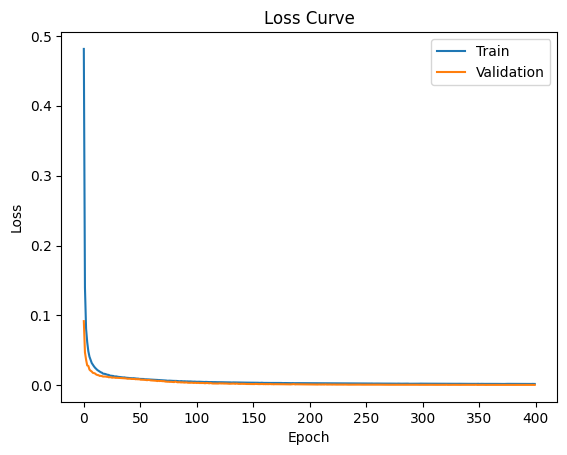

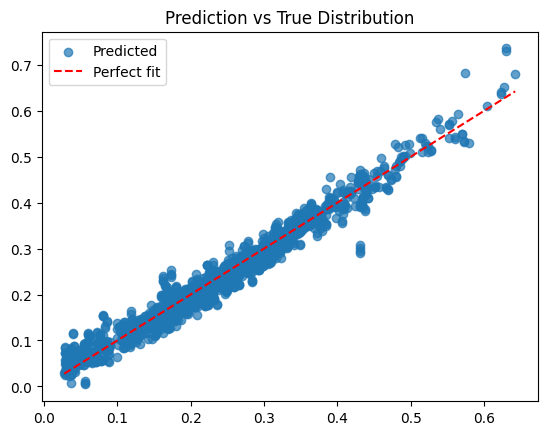

In [38]:
fig1, ax1 = plt.subplots()
ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Validation')
ax1.set_xlabel('Epoch')        
ax1.set_ylabel('Loss') 
ax1.set_title('Loss Curve')
ax1.legend()

fig2, ax2 = plt.subplots()
ax2.scatter(y_test, y_pred, alpha=0.7, label='Predicted')
ax2.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect fit') 
ax2.set_title('Prediction vs True Distribution')
ax2.legend()

In [39]:
data= "Augmented Data"
encoding_method= '1 Hot Encoding + PE'
feature_engineering= "With Feature Engineering"
run_id = 3
model_type = "MLP + Attention"
hyperparameters = {
    "epochs": 400,
    "batch_size": 32,
    "learning_rate": 1e-4
}

plots = {
    "Loss Curve": fig1,
    "Predicted vs. True Distribution": fig2
}

save_run(model_type, model, data, encoding_method, feature_engineering, run_id, hyperparameters, metrics, plots)

Done


# CNN

### Normal CNN

In [33]:
#seq_len=20 #With one-hot encoding
#seq_input = Input(shape=(seq_len,4), name='seq_input') #With one-hot encoding
seq_len = 64  #With k-mers encoding
seq_input = Input(shape=(seq_len, 1), name="seq_input") #With k-mers encoding

x1 = Conv1D(64, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(seq_input)
x1 = MaxPooling1D(pool_size=2)(x1)
x1 = BatchNormalization()(x1)

x1 = Conv1D(128, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x1)
x1 = MaxPooling1D(pool_size=2)(x1)
x1 = BatchNormalization()(x1)

x1 = Conv1D(128, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x1)
x1 = MaxPooling1D(pool_size=2)(x1)
x1 = BatchNormalization()(x1)

x1 = GlobalMaxPooling1D()(x1)

features_input = Input(shape=(X_num_train.shape[1],), name='num_input')
x2 = Dense(64, activation='relu', kernel_initializer='he_normal')(features_input)
x2 = BatchNormalization()(x2)

all_input = concatenate([x1, x2])
z = Dense(128, activation='relu', kernel_initializer='he_normal')(all_input)
z = Dropout(0.2)(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(1, activation='linear')(z)

optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)
model = Model(inputs=[seq_input, features_input], outputs=z)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history = model.fit(
    {'seq_input': X_seq_train, 'num_input': X_num_train},
    y_train,
    validation_data=({'seq_input': X_seq_test, 'num_input': X_num_test}, y_test),
    epochs= 400,
    batch_size= 32
)

Epoch 1/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.5027 - mae: 0.5238 - val_loss: 0.0459 - val_mae: 0.1672
Epoch 2/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0693 - mae: 0.2048 - val_loss: 0.0259 - val_mae: 0.1266
Epoch 3/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0358 - mae: 0.1475 - val_loss: 0.0190 - val_mae: 0.1073
Epoch 4/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0295 - mae: 0.1327 - val_loss: 0.0163 - val_mae: 0.0992
Epoch 5/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0219 - mae: 0.1156 - val_loss: 0.0165 - val_mae: 0.0995
Epoch 6/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0189 - mae: 0.1080 - val_loss: 0.0148 - val_mae: 0.0942
Epoch 7/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0176 - mae: 0.1042 - val_loss: 0.0140 - val_mae: 0.0910
Epoch 8/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0161 - mae: 0.0991 - val_loss: 0.0149 - val_mae: 0.0940
Epoch 9/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/

In [34]:
y_pred= model.predict({'seq_input': X_seq_test, 'num_input': X_num_test})
y_pred = y_pred.ravel()
y_test = y_test.ravel()

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [35]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
spearman_corr, _ = spearmanr(y_test, y_pred)

metrics = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2,
    'Spearman': spearman_corr
}

print("MLP Evaluation Metrics:")
print(f"  MSE      : {round(mse,3)}")
print(f"  RMSE     : {round(rmse,3)}")
print(f"  MAE      : {round(mae,3)}")
print(f"  R2 Score : {round(r2,3)}")
print(f"  Spearman : {round(spearman_corr,3)}")

MLP Evaluation Metrics:
  MSE      : 0.005
  RMSE     : 0.073
  MAE      : 0.054
  R2 Score : 0.59
  Spearman : 0.741


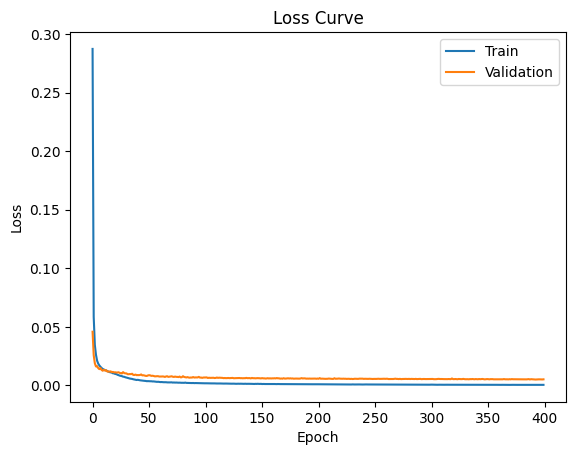

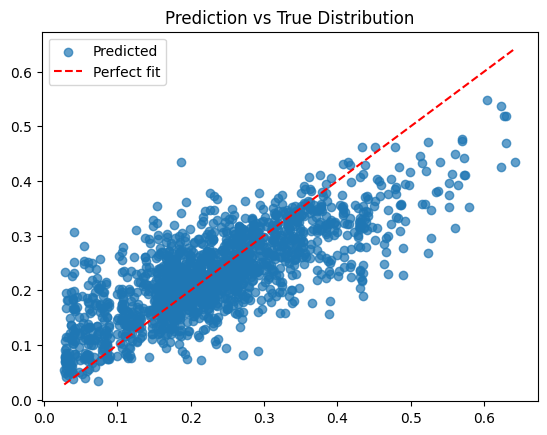

In [36]:
fig1, ax1 = plt.subplots()
ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Validation')
ax1.set_xlabel('Epoch')        
ax1.set_ylabel('Loss') 
ax1.set_title('Loss Curve')
ax1.legend()

fig2, ax2 = plt.subplots()
ax2.scatter(y_test, y_pred, alpha=0.7, label='Predicted')
ax2.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect fit') 
ax2.set_title('Prediction vs True Distribution')
ax2.legend()

In [37]:
data= "Augmented Data"
encoding_method= 'K-mers Encoding'
feature_engineering= "With Feature Engineering"
run_id = 5
model_type = "CNN"
hyperparameters = {
    "epochs": 400,
    "batch_size": 32,
    "learning_rate": 1e-4
}

plots = {
    "Loss Curve": fig1,
    "Predicted vs. True Distribution": fig2
}

save_run(model_type, model, data, encoding_method, feature_engineering, run_id, hyperparameters, metrics, plots)

Done


### CNN with Attention

In [ ]:
seq_len=20 
d_model = 16 

seq_input = Input(shape=(seq_len,4), name='seq_input') 
x = Dense(d_model, use_bias=False)(seq_input)  # (Projection)
position_embed = Embedding(input_dim=seq_len, output_dim=d_model)

def add_positional_encoding(t):
    pe = position_embed(tf.range(seq_len))                        
    return t + tf.expand_dims(pe, 0)

x = Lambda(add_positional_encoding, name='add_pos')(x)   

attention_output = MultiHeadAttention(num_heads=2, key_dim=d_model // 2, dropout=0.1, name='self_attn')(x, x)     

x = Add(name='attn_res')([x, attention_output])
x = LayerNormalization(name='attn_ln')(x)     

x1 = Conv1D(64, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
x1 = MaxPooling1D(pool_size=2)(x1)
x1 = BatchNormalization()(x1)

x1 = Conv1D(128, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x1)
x1 = MaxPooling1D(pool_size=2)(x1)
x1 = BatchNormalization()(x1)

x1 = Conv1D(128, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x1)
x1 = MaxPooling1D(pool_size=2)(x1)
x1 = BatchNormalization()(x1)

x1 = GlobalMaxPooling1D()(x1)

features_input = Input(shape=(X_num_train.shape[1],), name='num_input')
x2 = Dense(64, activation='relu', kernel_initializer='he_normal')(features_input)
x2 = BatchNormalization()(x2)

all_input = concatenate([x1, x2])
z = Dense(128, activation='relu', kernel_initializer='he_normal')(all_input)
z = Dropout(0.2)(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(1, activation='linear')(z)

optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)
model = Model(inputs=[seq_input, features_input], outputs=z)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history = model.fit(
    {'seq_input': X_seq_train, 'num_input': X_num_train},
    y_train,
    validation_data=({'seq_input': X_seq_test, 'num_input': X_num_test}, y_test),
    epochs= 400,
    batch_size= 32
)

Epoch 1/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.6258 - mae: 0.5916 - val_loss: 0.0651 - val_mae: 0.2033
Epoch 2/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0949 - mae: 0.2436 - val_loss: 0.0365 - val_mae: 0.1532
Epoch 3/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0532 - mae: 0.1829 - val_loss: 0.0265 - val_mae: 0.1295
Epoch 4/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0365 - mae: 0.1503 - val_loss: 0.0220 - val_mae: 0.1169
Epoch 5/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0286 - mae: 0.1330 - val_loss: 0.0192 - val_mae: 0.1082
Epoch 6/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0237 - mae: 0.1204 - val_loss: 0.0177 - val_mae: 0.1040
Epoch 7/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0207 - mae: 0.1130 - val_loss: 0.0155 - val_mae: 0.0979
Epoch 8/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0186 - mae: 0.1066 - val_loss: 0.0149 - val_mae: 0.0958
Epoch 9/400
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/

In [35]:
y_pred= model.predict({'seq_input': X_seq_test, 'num_input': X_num_test})
y_pred = y_pred.ravel()
y_test = y_test.ravel()

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [36]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
spearman_corr, _ = spearmanr(y_test, y_pred)

metrics = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2,
    'Spearman': spearman_corr
}

print("MLP Evaluation Metrics:")
print(f"  MSE      : {round(mse,3)}")
print(f"  RMSE     : {round(rmse,3)}")
print(f"  MAE      : {round(mae,3)}")
print(f"  R2 Score : {round(r2,3)}")
print(f"  Spearman : {round(spearman_corr,3)}")

MLP Evaluation Metrics:
  MSE      : 0.001
  RMSE     : 0.024
  MAE      : 0.016
  R2 Score : 0.956
  Spearman : 0.981


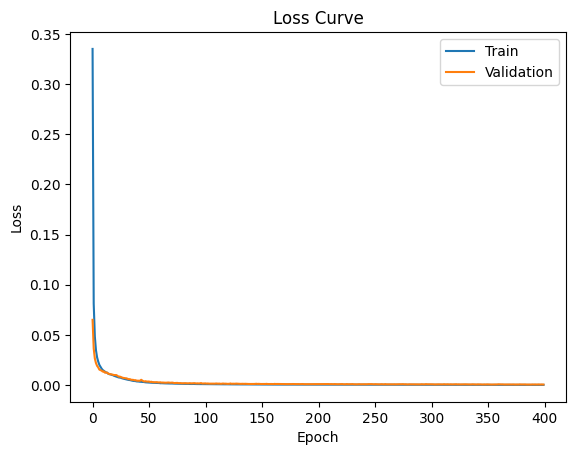

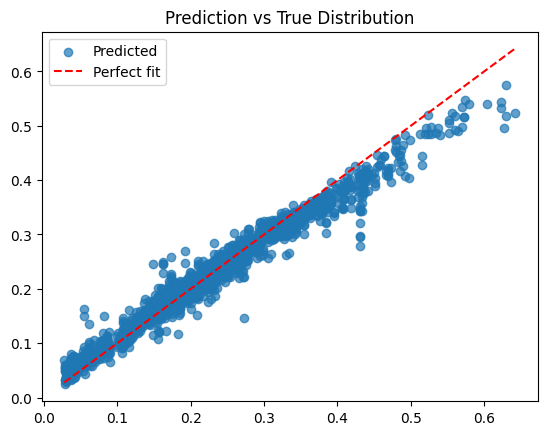

In [37]:
fig1, ax1 = plt.subplots()
ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Validation')
ax1.set_xlabel('Epoch')        
ax1.set_ylabel('Loss') 
ax1.set_title('Loss Curve')
ax1.legend()

fig2, ax2 = plt.subplots()
ax2.scatter(y_test, y_pred, alpha=0.7, label='Predicted')
ax2.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect fit') 
ax2.set_title('Prediction vs True Distribution')
ax2.legend()

In [38]:
data= "Augmented Data"
encoding_method= '1 Hot Encoding + PE'
feature_engineering= "With Feature Engineering"
run_id = 6
model_type = "CNN + Attention"
hyperparameters = {
    "epochs": 400,
    "batch_size": 32,
    "learning_rate": 1e-4
}

plots = {
    "Loss Curve": fig1,
    "Predicted vs. True Distribution": fig2
}

save_run(model_type, model, data, encoding_method, feature_engineering, run_id, hyperparameters, metrics, plots)

Done


# BiLSTM

### Normal BiLSTM

In [33]:
#seq_len=20 #With one-hot encoding
#seq_input = Input(shape=(seq_len,4), name='seq_input') #With one-hot encoding
seq_len = 64  #With k-mers encoding
seq_input = Input(shape=(seq_len,1), name="seq_input") #With k-mers encoding

x1 = Bidirectional(LSTM(64, return_sequences=True))(seq_input)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)

x1 = Bidirectional(LSTM(128, return_sequences=True))(x1)
x1 = GlobalMaxPooling1D()(x1)
x1 = BatchNormalization()(x1)

features_input = Input(shape=(X_num_train.shape[1],), name='num_input')
x2 = Dense(64, activation='relu', kernel_initializer='he_normal')(features_input)
x2 = BatchNormalization()(x2)

all_input = concatenate([x1, x2])
z = Dense(128, activation='relu', kernel_initializer='he_normal')(all_input)
z = Dropout(0.2)(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(1, activation='linear')(z)

optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)
model = Model(inputs=[seq_input, features_input], outputs=z)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history = model.fit(
    {'seq_input': X_seq_train, 'num_input': X_num_train},
    y_train,
    validation_data=({'seq_input': X_seq_test, 'num_input': X_num_test}, y_test),
    epochs= 250,
    batch_size= 32
)

Epoch 1/250
208/208 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - loss: 0.3124 - mae: 0.4218 - val_loss: 0.0552 - val_mae: 0.2020
Epoch 2/250
208/208 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 0.0881 - mae: 0.2321 - val_loss: 0.0569 - val_mae: 0.2052
Epoch 3/250
208/208 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 0.0607 - mae: 0.1934 - val_loss: 0.0292 - val_mae: 0.1330
Epoch 4/250
208/208 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 0.0404 - mae: 0.1578 - val_loss: 0.0281 - val_mae: 0.1311
Epoch 5/250
208/208 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 0.0343 - mae: 0.1459 - val_loss: 0.0236 - val_mae: 0.1219
Epoch 6/250
208/208 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 0.0288 - mae: 0.1342 - val_loss: 0.0190 - val_mae: 0.1078
Epoch 7/250
208/208 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 0.0253 - mae: 0.1258 - val_loss: 0.0219 - val_mae: 0.1153
Epoch 8/250
208/208 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - loss: 0.0237 - mae: 0.1203 - val_loss: 0.0175 - val_mae: 0.1018
Epoch 9/250
208/208 ━━━━━━━━━━━━━━━━━━

In [34]:
y_pred= model.predict({'seq_input': X_seq_test, 'num_input': X_num_test})
y_pred = y_pred.ravel()
y_test = y_test.ravel()

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


In [35]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
spearman_corr, _ = spearmanr(y_test, y_pred)

metrics = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2,
    'Spearman': spearman_corr
}

print("MLP Evaluation Metrics:")
print(f"  MSE      : {round(mse,3)}")
print(f"  RMSE     : {round(rmse,3)}")
print(f"  MAE      : {round(mae,3)}")
print(f"  R2 Score : {round(r2,3)}")
print(f"  Spearman : {round(spearman_corr,3)}")

MLP Evaluation Metrics:
  MSE      : 0.008
  RMSE     : 0.091
  MAE      : 0.07
  R2 Score : 0.352
  Spearman : 0.561


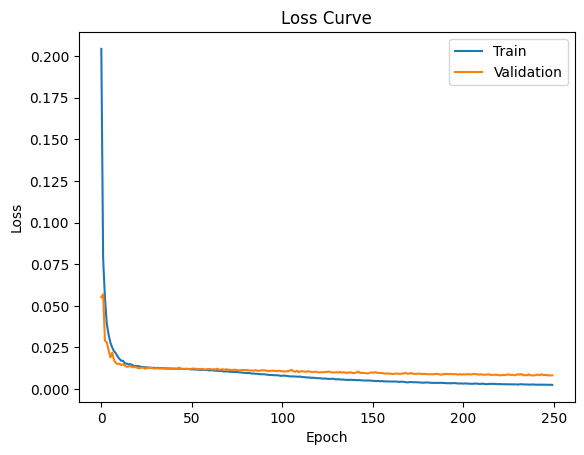

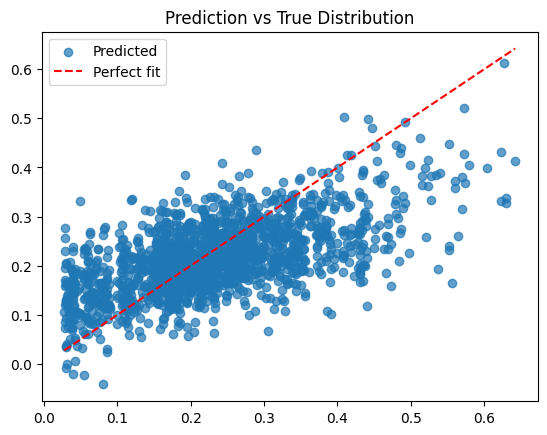

In [36]:
fig1, ax1 = plt.subplots()
ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Validation')
ax1.set_xlabel('Epoch')        
ax1.set_ylabel('Loss') 
ax1.set_title('Loss Curve')
ax1.legend()

fig2, ax2 = plt.subplots()
ax2.scatter(y_test, y_pred, alpha=0.7, label='Predicted')
ax2.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect fit') 
ax2.set_title('Prediction vs True Distribution')
ax2.legend()

In [37]:
data= "Augmented Data"
encoding_method= 'K-mers Encoding'
feature_engineering= "With Feature Engineering"
run_id = 8
model_type = "BiLSTM"
hyperparameters = {
    "epochs": 250,
    "batch_size": 32,
    "learning_rate": 1e-4
}

plots = {
    "Loss Curve": fig1,
    "Predicted vs. True Distribution": fig2
}

save_run(model_type, model, data, encoding_method, feature_engineering, run_id, hyperparameters, metrics, plots)

Done


### BiLSTM with Attention

In [ ]:
seq_len=20 
d_model = 16 

seq_input = Input(shape=(seq_len,4), name='seq_input') 

x = Dense(d_model, use_bias=False)(seq_input)  # (Projection)
position_embed = Embedding(input_dim=seq_len, output_dim=d_model)

def add_positional_encoding(t):
    pe = position_embed(tf.range(seq_len))                      
    return t + tf.expand_dims(pe, 0)

x = Lambda(add_positional_encoding, name='add_pos')(x)   

attention_output = MultiHeadAttention(num_heads=2, key_dim=d_model // 2, dropout=0.1, name='self_attn')(x, x)      

x = Add(name='attn_res')([x, attention_output])
x = LayerNormalization(name='attn_ln')(x)     

x1 = Bidirectional(LSTM(64, return_sequences=True))(x)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)

x1 = Bidirectional(LSTM(128, return_sequences=True))(x1)
x1 = GlobalMaxPooling1D()(x1)
x1 = BatchNormalization()(x1)

features_input = Input(shape=(X_num_train.shape[1],), name='num_input')
x2 = Dense(64, activation='relu', kernel_initializer='he_normal')(features_input)
x2 = BatchNormalization()(x2)

all_input = concatenate([x1, x2])
z = Dense(128, activation='relu', kernel_initializer='he_normal')(all_input)
z = Dropout(0.2)(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(1, activation='linear')(z)

optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)
model = Model(inputs=[seq_input, features_input], outputs=z)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history = model.fit(
    {'seq_input': X_seq_train, 'num_input': X_num_train},
    y_train,
    validation_data=({'seq_input': X_seq_test, 'num_input': X_num_test}, y_test),
    epochs= 250,
    batch_size= 32
)


Epoch 1/250
208/208 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.2792 - mae: 0.4045 - val_loss: 0.0235 - val_mae: 0.1207
Epoch 2/250
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0793 - mae: 0.2194 - val_loss: 0.0294 - val_mae: 0.1360
Epoch 3/250
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0509 - mae: 0.1788 - val_loss: 0.0248 - val_mae: 0.1242
Epoch 4/250
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0368 - mae: 0.1517 - val_loss: 0.0224 - val_mae: 0.1178
Epoch 5/250
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0311 - mae: 0.1392 - val_loss: 0.0187 - val_mae: 0.1072
Epoch 6/250
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0249 - mae: 0.1240 - val_loss: 0.0175 - val_mae: 0.1030
Epoch 7/250
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0232 - mae: 0.1197 - val_loss: 0.0156 - val_mae: 0.0968
Epoch 8/250
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0202 - mae: 0.1114 - val_loss: 0.0137 - val_mae: 0.0907
Epoch 9/250
208/208 ━━━━━━━━━━━━━━━━━━━

In [40]:
y_pred= model.predict({'seq_input': X_seq_test, 'num_input': X_num_test})
y_pred = y_pred.ravel()
y_test = y_test.ravel()

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [41]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
spearman_corr, _ = spearmanr(y_test, y_pred)

metrics = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2,
    'Spearman': spearman_corr
}

print("MLP Evaluation Metrics:")
print(f"  MSE      : {round(mse,3)}")
print(f"  RMSE     : {round(rmse,3)}")
print(f"  MAE      : {round(mae,3)}")
print(f"  R2 Score : {round(r2,3)}")
print(f"  Spearman : {round(spearman_corr,3)}")

MLP Evaluation Metrics:
  MSE      : 0.0
  RMSE     : 0.021
  MAE      : 0.016
  R2 Score : 0.967
  Spearman : 0.982


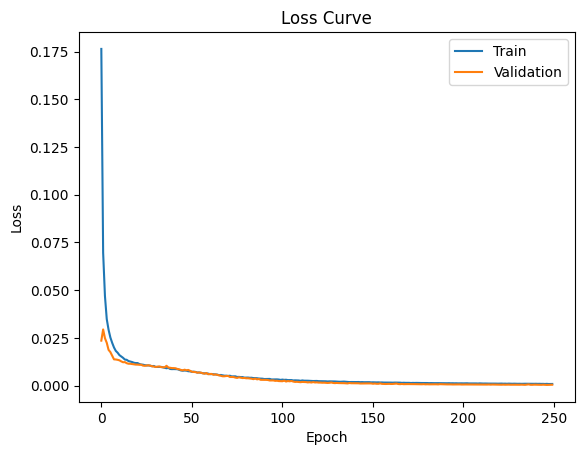

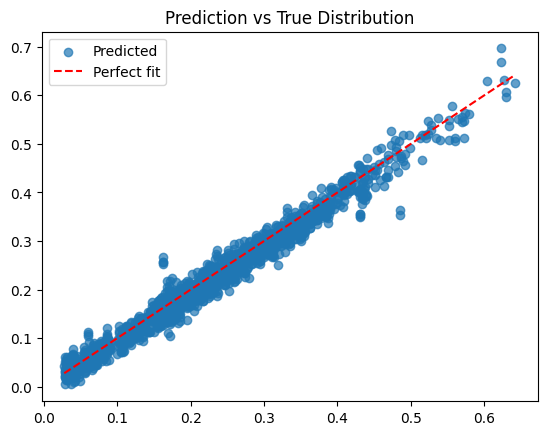

In [42]:
fig1, ax1 = plt.subplots()
ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Validation')
ax1.set_xlabel('Epoch')        
ax1.set_ylabel('Loss') 
ax1.set_title('Loss Curve')
ax1.legend()

fig2, ax2 = plt.subplots()
ax2.scatter(y_test, y_pred, alpha=0.7, label='Predicted')
ax2.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect fit') 
ax2.set_title('Prediction vs True Distribution')
ax2.legend()

In [43]:
data= "Augmented Data"
encoding_method= '1 Hot Encoding + PE'
feature_engineering= "With Feature Engineering"
run_id = 9
model_type = "BiLSTM + Attention"
hyperparameters = {
    "epochs": 250,
    "batch_size": 32,
    "learning_rate": 1e-4
}

plots = {
    "Loss Curve": fig1,
    "Predicted vs. True Distribution": fig2
}

save_run(model_type, model, data, encoding_method, feature_engineering, run_id, hyperparameters, metrics, plots)

Done
